In [1]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

In [2]:
#Save Kyoto_Gases data (2020-2100), consider the case of C1-C8 for simplicity.
Kyoto_Gases = pd.read_csv('Kyoto Gases.csv')
X_Emissions = Kyoto_Gases
X_Emissions = X_Emissions[X_Emissions['Category'].isin(['C1','C2','C3','C4','C5','C6','C7','C8'])]
X_Emissions.reset_index(drop=True,inplace=True)
mapping = {'C1':0,'C2':0,'C3':0,'C4':1,'C5':1,'C6':1,'C7':2,'C8':2}
X_Emissions['Category'].replace(mapping,inplace=True)
X_Emissions.drop(columns=['Category_name'],inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
#Merge models according to a uniform standard
MESSAGEix = list(set([i for i in X_Emissions['Model'] if  'MESSAGE' in i]))
WITCH = list(set([i for i in X_Emissions['Model'] if  'WITCH' in i]))
COFFEE = ['COFFEE 1.1']
REMIND = list(set([i for i in X_Emissions['Model'] if  'REM' in i]))
TIA = list(set([i for i in X_Emissions['Model'] if  'TIAM-ECN' in i]))
POL = list(set([i for i in X_Emissions['Model'] if  'POL' in i]))
AIM = list(set([i for i in X_Emissions['Model'] if  'AIM' in i]))
IMA = list(set([i for i in X_Emissions['Model'] if  'IMAGE' in i]))
GCA = list(set([i for i in X_Emissions['Model'] if  'GCA' in i]))

In [4]:
Model = [MESSAGEix,WITCH,COFFEE,REMIND,TIA,POL,AIM,IMA,GCA]
Model_names = ['MESSAGEix','WITCH','COFFEE','REMIND','TIA','POL','AIM','IMA','GCA']
Model_List = []
for i in Model:
    Model_List += i

In [5]:
X_Emissions = X_Emissions[X_Emissions['Model'].isin(Model_List)]

In [6]:
mapping = {j:Model_names[i] for i in range(len(Model)) for j in Model[i]}
X_Emissions['Model'].replace(mapping,inplace=True)
X_Emissions.reset_index(drop=True,inplace=True)

In [7]:
#Load a dataset of individual variables
CarbonSequestration = pd.read_csv('Carbon_Sequestration_CCS_imputed.csv')
FinalEnergy_Gase = pd.read_csv('Final Energy_Gases.csv')
FinalEnergy_Liquid = pd.read_csv('Final Energy_Liquids.csv')
FinalEnergy_Solid = pd.read_csv('Final Energy_Solids.csv')
FinalEnergy = pd.read_csv('Final_Energy_ts_imputed.csv')
PrimaryEnergy_Gas = pd.read_csv('Primary Energy_Gas.csv')
PrimaryEnergy_Oil = pd.read_csv('Primary Energy_Oil.csv')
PrimaryEnergy_Solar = pd.read_csv('Primary Energy_Solar.csv')
PrimaryEnergy_Coal = pd.read_csv('PrimaryEnergy_Coal.csv')
PrimaryEnergy = pd.read_csv('PrimaryEnergy_imputed.csv')
SecondaryEnergy_Gas = pd.read_csv('Secondary Energy_Gases.csv')
SecondaryEnergy_Liquid = pd.read_csv('Secondary Energy_Liquids.csv')
SecondaryEnergy_Electricity = pd.read_csv('SecondaryEnergyElectricity_imputed.csv')

In [8]:
#Get the intersection of the models and scenarios contained in each variable
baseline = X_Emissions[['Model','Scenario']]
Variables = [CarbonSequestration,FinalEnergy,FinalEnergy_Gase,FinalEnergy_Liquid,FinalEnergy_Solid,PrimaryEnergy,PrimaryEnergy_Coal,PrimaryEnergy_Gas,PrimaryEnergy_Oil,PrimaryEnergy_Solar,SecondaryEnergy_Electricity,SecondaryEnergy_Gas,SecondaryEnergy_Liquid]
for i in range(len(Variables)):
    Variables[i]['Model'].replace(mapping,inplace=True)
for variable in Variables:
    baseline = pd.merge(baseline,variable[['Model','Scenario']],on=['Model','Scenario'],how='inner')

In [9]:
for i in range(len(Variables)):
     Variables[i] = pd.merge(baseline,Variables[i],on=['Model','Scenario'],how='inner')

In [10]:
X_Emissions = pd.merge(X_Emissions,baseline,on = ['Model','Scenario'],how = 'inner')
Y = X_Emissions['Category'].values

In [11]:
Features1 = np.zeros((996,13))#Feature_Sum:13 Features Accumulation from 2010 to 2100
for i in range(996):
    for j in range(len(Variables)):
        X = Variables[j].iloc[:,2:-2].values
        for k in range(9):
            Features1[i][j] += (X[i][k] + X[i][k+1]) * 5
Features2 = np.zeros((996,13))#Feature_2010_2030:13 Features Rate of change 2010-2030
for i in range(996):
    for j in range(len(Variables)):
        X = Variables[j].iloc[:,2:-2].values
        Features2[i][j] = (X[i][2] - X[i][0]) / 20
Features3 = np.zeros((996,13))#Feature_2030_2050:13 Features Rate of change 2030-2050
for i in range(996):
    for j in range(len(Variables)):
        X = Variables[j].iloc[:,2:-2].values
        Features3[i][j] = (X[i][4] - X[i][2]) / 20
Features = np.concatenate((Features1,Features2,Features3),axis=1)

In [12]:
Emissions = np.zeros(X_Emissions.shape[0])#Kyoto_Gases Accumulation from 2020 to 2100
X = X_Emissions.iloc[:,3:-1].values
for i in range(X.shape[0]):
    for k in range(X.shape[1] - 1):
        Emissions[i] += (X[i][k] + X[i][k+1]) * 5

In [13]:
columns_names1 = ['CarbonSequestration','FinalEnergy','FinalEnergy_Gase','FinalEnergy_Liquid','FinalEnergy_Solid','PrimaryEnergy','PrimaryEnergy_Coal','PrimaryEnergy_Gas','PrimaryEnergy_Oil','PrimaryEnergy_Solar','SecondaryEnergy_Electricity','SecondaryEnergy_Gas','SecondaryEnergy_Liquid']
columns_names2 = [feature + '2010-2030' for feature in columns_names1]
columns_names3 = [feature + '2030-2050' for feature in columns_names1]
columns_names = columns_names1 + columns_names2 + columns_names3
DataSet = pd.DataFrame(Features,columns = columns_names)
DataSet['Emissions'] = Emissions
DataSet['Category'] = Y

In [14]:
DataSet_sorted = DataSet.sort_values(by='Category')
DataSet_sorted.reset_index(drop=True,inplace=True)

In [15]:
DataSet_sorted['Category'].value_counts()

0    427
1    418
2    151
Name: Category, dtype: int64

In [16]:
DataSet_sorted.drop(columns=['Category'],inplace=True)

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()#Standardize the data
processed_data = pd.DataFrame(scaler.fit_transform(DataSet_sorted), columns=DataSet_sorted.columns)

In [18]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [19]:
#partition dataset
X_train, X_test, y_train, y_test = train_test_split(processed_data.drop(columns=['Emissions']), processed_data['Emissions'], test_size=0.2, random_state=42)

In [20]:
#Cross-validation using grid search
model = xgb.XGBRegressor(objective='reg:squarederror',random_state = 5)
parameters = {
    'n_estimators':[10,100,200,500,1000],
    'max_depth':[6,8,10,12,14,16],
    'reg_alpha':[0.01,0.1,0.2,0.25]
}
grid_search = GridSearchCV(model,param_grid=parameters,cv=5,n_jobs=-1,verbose=2,scoring='r2')
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=5, ...),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10, 12, 14, 16],
                         'n_estimators': [10, 100, 200, 500, 1000],
                         'reg_alpha': [0.01, 0.1, 0.2, 0.25]},
             scoring='r2', verbose=2)

In [21]:
print('Best parameters found:')
print(grid_search.best_params_)

Best parameters found:
{'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0.1}


In [22]:
model = xgb.XGBRegressor(objective='reg:squarederror',max_depth=6,n_estimators=100,reg_alpha=0.1,random_state=5)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error on test set：", mse)

Mean squared error on test set： 0.015054084955519005


In [23]:
y_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print("Mean squared error on the training dataset：", mse)

Mean squared error on the training dataset： 0.0003176399439613624


In [24]:
explainer = shap.Explainer(model, processed_data)
shap_values = explainer(processed_data)

[22:44:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


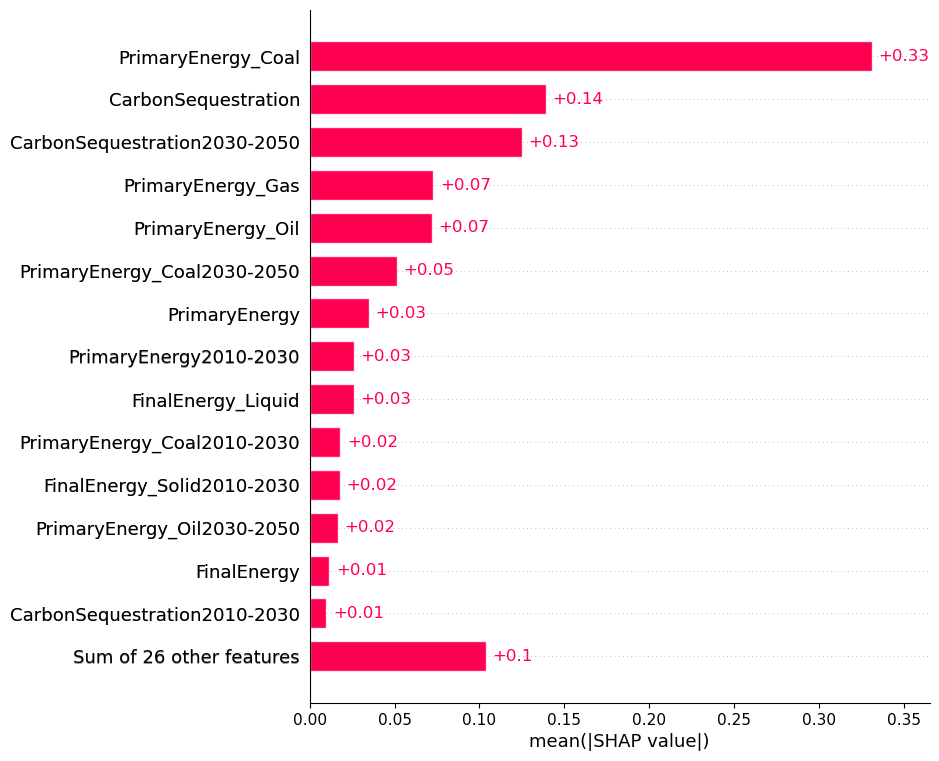

In [25]:
shap.plots.bar(shap_values,max_display=15,show=False)
#plt.savefig('Bar_Time.pdf', format='pdf', dpi=600, bbox_inches='tight')

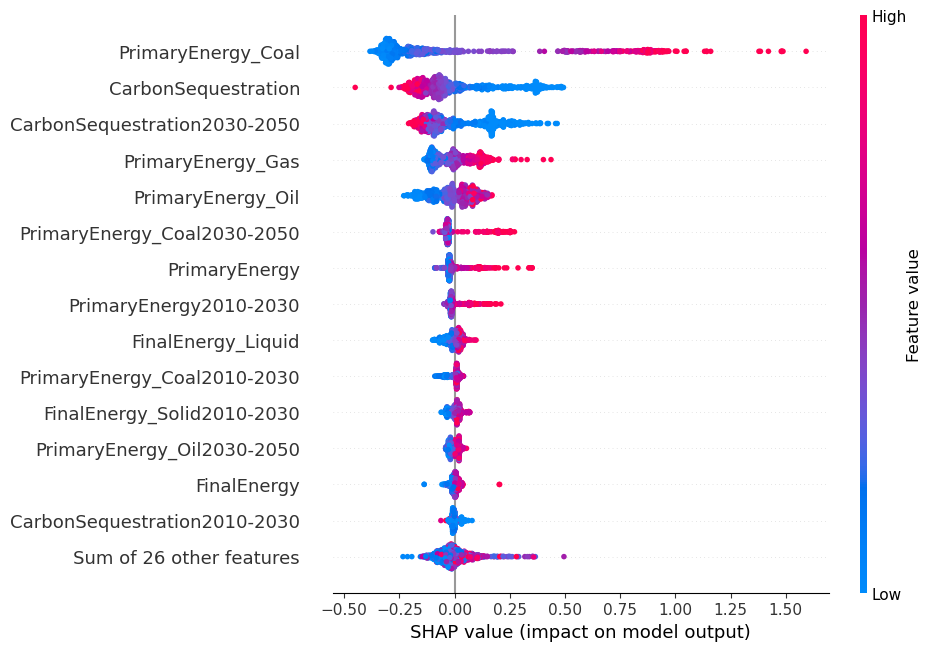

In [26]:
shap.plots.beeswarm(shap_values, max_display=15,show=False)
#plt.savefig('Beeswarm_Time_6.pdf', format='pdf', dpi=600, bbox_inches='tight')

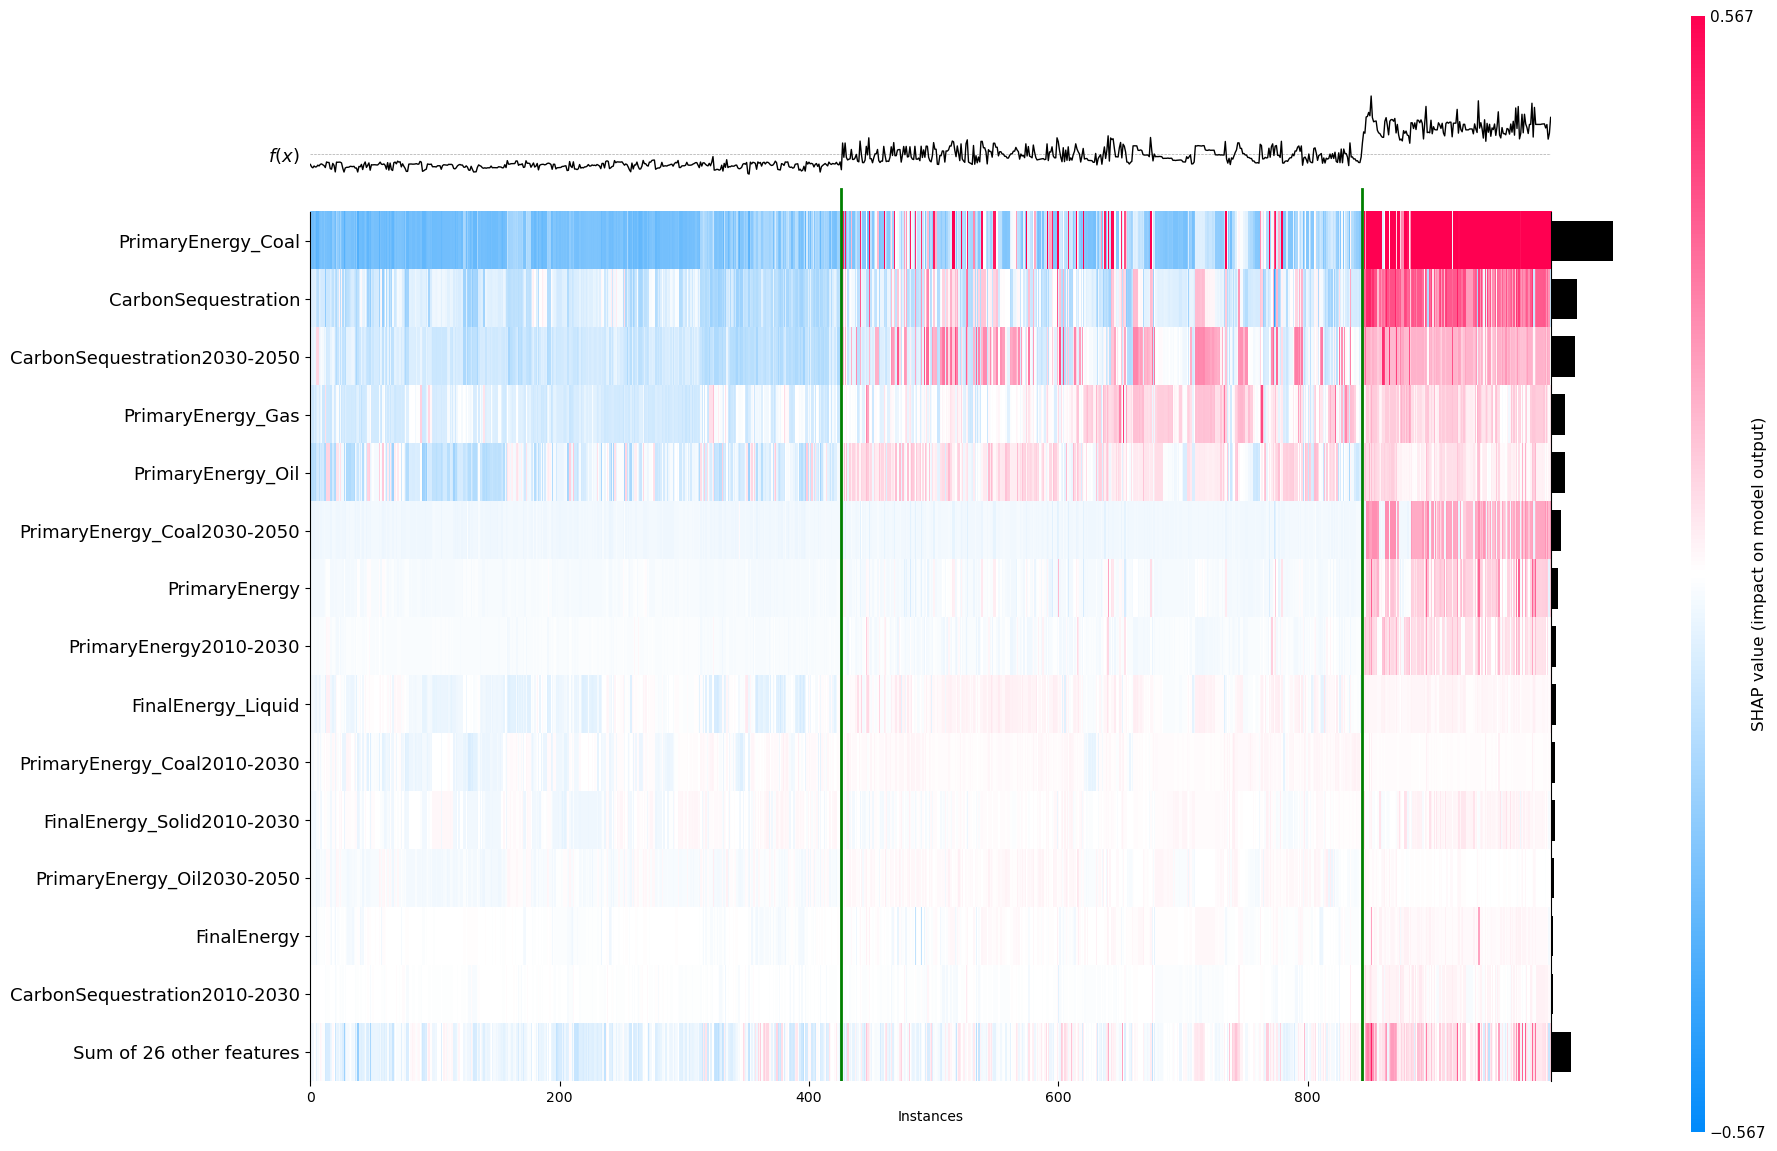

In [27]:
shap.plots.heatmap(shap_values, max_display=15,show=False,instance_order=np.arange(X_Emissions.shape[0]))
_, h = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(h*1.8, 3.2*h)
# Use the green vertical line to distinguish categories（Agg-Category） in the diagram
plt.gca()
plt.axvline(x=426, color='green', linestyle='-', linewidth=2,ymax=0.88)
plt.axvline(x=844, color='green', linestyle='-', linewidth=2,ymax=0.88)
#plt.savefig('Heatmap_Time.pdf', format='pdf', dpi=600, bbox_inches='tight')

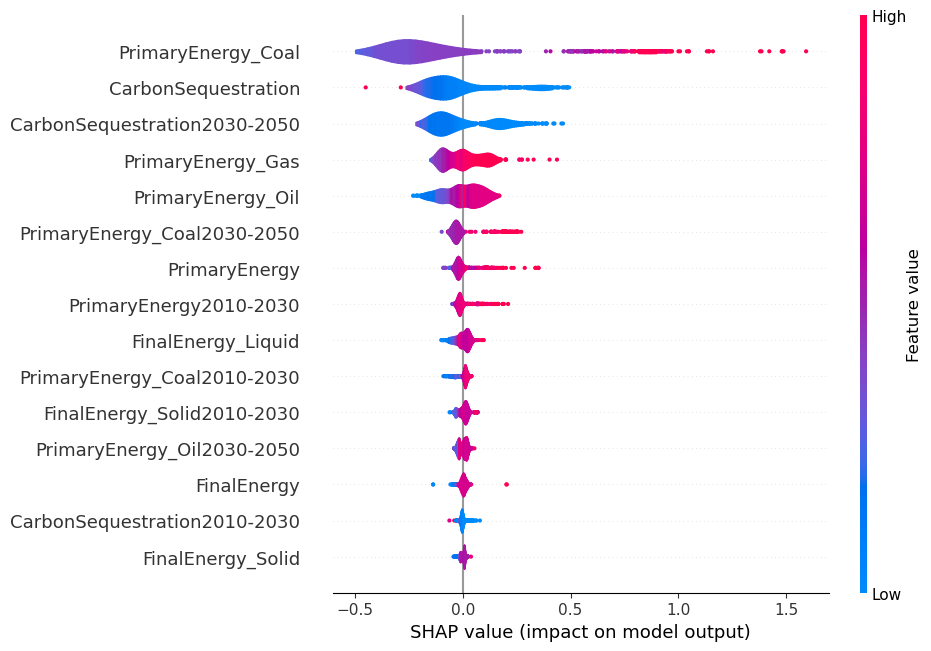

In [28]:
shap.plots.violin(shap_values,max_display=15,show=False)
#plt.savefig('Violin_Time.pdf', format='pdf', dpi=600, bbox_inches='tight')


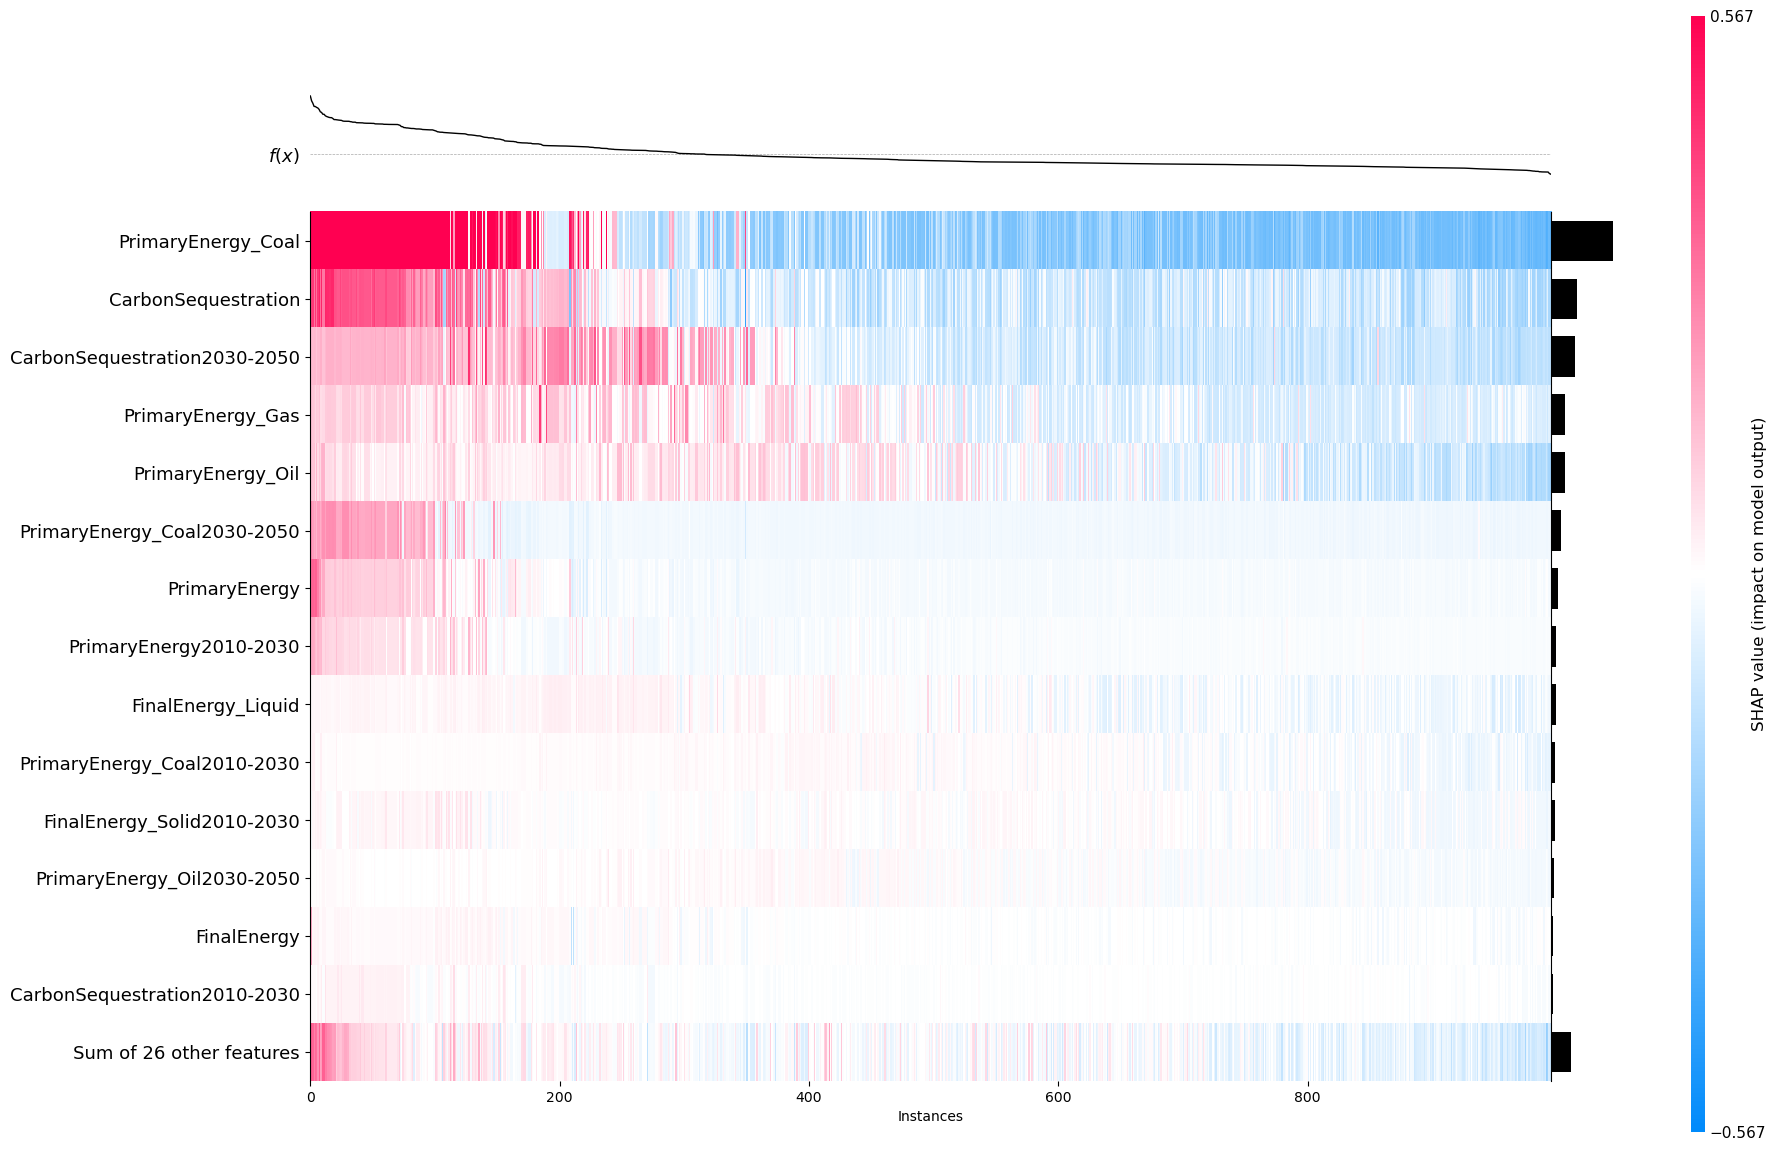

In [29]:
#Sorting by Kyoto_Gases
shap.plots.heatmap(shap_values, max_display=15,show=False,instance_order=shap_values.sum(1))
_, h = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(h*1.8, 3.2*h)
#plt.savefig('Heatmap_Time.pdf', format='pdf', dpi=600, bbox_inches='tight')